<a href="https://colab.research.google.com/github/sarmientoj24/EE298/blob/master/Denoising_Autoencoder_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# Remove annoying warnings from tensorflow
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, MaxPooling2D, BatchNormalization
from keras.layers import Reshape, Conv2DTranspose, Dropout, Activation
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import random

# np.random.seed(1337)

def create_random_noise_box(x):
  size = x.shape[1]
  gen_size = np.random.randint(7, 14)
  random_x = np.random.randint(0, size - gen_size)
  random_y = np.random.randint(0, size - gen_size)
  
  white_block = np.ones((gen_size, gen_size))
  white_block.fill(255)
  
  x[random_x: random_x + gen_size, random_y : random_y + gen_size] = white_block
  return x

# Everbody...
def make_some_noise(x):
  num_of_images = x.shape[0]
  for i in range(num_of_images):
    x[i] = create_random_noise_box(x[i])
  return x

# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
image_size = x_train.shape[1]

x_train_noisy = x_train.copy()
x_train_noisy = make_some_noise(x_train_noisy)
x_test_noisy = x_test.copy()
x_test_noisy = make_some_noise(x_test_noisy)

x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_test = x_test.astype('float32') / 255

x_train_noisy = np.reshape(x_train_noisy, [-1, image_size, image_size, 1])
x_train_noisy = x_train_noisy.astype('float32') / 255
x_test_noisy = np.reshape(x_test_noisy, [-1, image_size, image_size, 1])
x_test_noisy = x_test_noisy.astype('float32') / 255


In [0]:
def show_image_reconstructions(decoded, noisy):
  n = 10  # how many digits we will display
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(decoded[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(noisy[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

In [0]:
import warnings
warnings.filterwarnings("ignore")
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
    
class AutoEncoder():
  kernel_size = 3
  pool_size = (2,2)
  
  def __init__(self, image_size):
    input_shape = (image_size, image_size, 1)
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs

    x = Conv2D(filters=16,
               kernel_size=self.kernel_size,
               strides=1,
               activation = 'relu',
               padding='same')(x)
    
    x = Conv2D(filters=8,
               kernel_size=self.kernel_size,
               strides=1,
               padding='same')(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D(self.pool_size, padding='same')(x)
    
    
    # stack of Conv2DTranspose(64)-Conv2DTranspose(32)
    # Inverted Maxpool
    x = Conv2DTranspose(filters=8,
                        kernel_size=self.pool_size,
                        strides=2,
                        padding='same')(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(filters=8,
                        kernel_size=self.kernel_size,
                        strides=1,
                        padding='same')(x)
    
    x = Conv2DTranspose(filters=16,
                        kernel_size=self.kernel_size,
                        strides=1,
                        activation='relu',
                        padding='same')(x)

    # reconstruct the denoised input
    outputs = Conv2DTranspose(filters=1,
                              kernel_size=self.kernel_size,
                              padding='same',
                              activation='sigmoid',
                              name='decoder_output')(x)

    self.model = Model(inputs, outputs, name='autoencoder')
    
  def summarize(self):
    self.model.summary()
  
  def get_model(self):
    return self.model
  
  def get_encoder(self):
    return self.encoder
  
  def get_decoder(self):
    return self.decoder
  
  def summarize_encoder(self):
    return self.encoder.summary()
  
  def summarize_decoder(self):
    return self.decoder.summary()
  
  def _compile(self, loss, optimizer):
    self.model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
  def _train(self, x_train, y_train, x_val, y_val, epochs, batch_size):
    # train the autoencoder
    self.history = self.model.fit(x_train,
                   y_train,
                   validation_data=(x_val, y_val),
                   epochs=epochs,
                   batch_size=batch_size,
                   verbose=1)
  
  def _predict(self, x_test):
    return self.model.predict(x_test)
  
  def save_autoencoder(self):
    plot_model(self.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
  def get_history(self):
    return self.history

In [0]:
def plotLosses(history, ax):  
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  title = 'Model loss'
  ax.set_title(title)
  ax.set(xlabel='Epoch', ylabel='Loss')
  ax.legend(['Train', 'Test'], loc='upper right')
    
def plotAccuracy(history, ax):  
  ax.plot(history.history['acc'])
  ax.plot(history.history['val_acc'])
  title = 'Model Accuracy'
  ax.set_title(title)
  ax.set(xlabel='Epoch', ylabel='Accuracy')
  ax.legend(['Train', 'Test'], loc='lower right')
    
def get_accuracy(truth, preds):
  acc = np.mean(np.equal(truth, preds))
  print("Accuracy: {0:.2f}".format(acc * 100))
  return acc
                
def visualize(history):
  fig_loss, axes = plt.subplots(nrows=1, ncols=2)
  plotLosses(history, axes[0])
  plotAccuracy(history, axes[1])
  fig_loss.tight_layout()

In [45]:
loss = 'mse'
optimizer = 'adadelta'

autoencoder = AutoEncoder(image_size)
autoencoder._compile(loss, optimizer)
autoencoder.save_autoencoder()
autoencoder.summarize()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 8)         1160      
_________________________________________________________________
batch_normalization_29 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_23 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_transpose_48 (Conv2DT (None, 28, 28, 8)         

In [47]:
batch_size = 16
epochs = 20
print("Training autoencoder")
autoencoder._train(x_train_noisy,
                x_train,
                x_test_noisy, 
                x_test,
                epochs=epochs,
                batch_size=batch_size)

Training autoencoder
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 50s 835us/step - loss: 0.0109 - acc: 0.8126 - val_loss: 0.0114 - val_acc: 0.8123
Epoch 2/20
60000/60000 [==============================] - 50s 839us/step - loss: 0.0108 - acc: 0.8126 - val_loss: 0.0112 - val_acc: 0.8117
Epoch 3/20
60000/60000 [==============================] - 50s 833us/step - loss: 0.0108 - acc: 0.8126 - val_loss: 0.0109 - val_acc: 0.8114
Epoch 4/20
60000/60000 [==============================] - 50s 830us/step - loss: 0.0108 - acc: 0.8126 - val_loss: 0.0109 - val_acc: 0.8114
Epoch 5/20
60000/60000 [==============================] - 50s 826us/step - loss: 0.0108 - acc: 0.8126 - val_loss: 0.0108 - val_acc: 0.8113
Epoch 6/20
60000/60000 [==============================] - 50s 835us/step - loss: 0.0107 - acc: 0.8126 - val_loss: 0.0107 - val_acc: 0.8120
Epoch 7/20
60000/60000 [==============================] - 50s 832us/step - loss: 0.0107 - acc: 

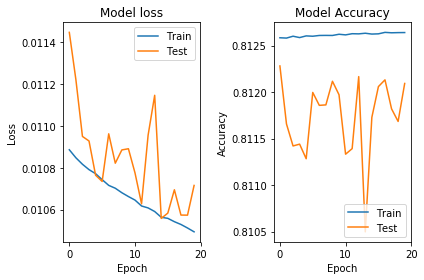

In [48]:
visualize(autoencoder.get_history())
'''
Observation: Quickly reached 0.80 training accuracy, validation accuracy also reached 0.8 quickly, but bounces back a lot
Loss had minimal change all throughout but generally cascading
Increasing epoch does nothing significant
'''

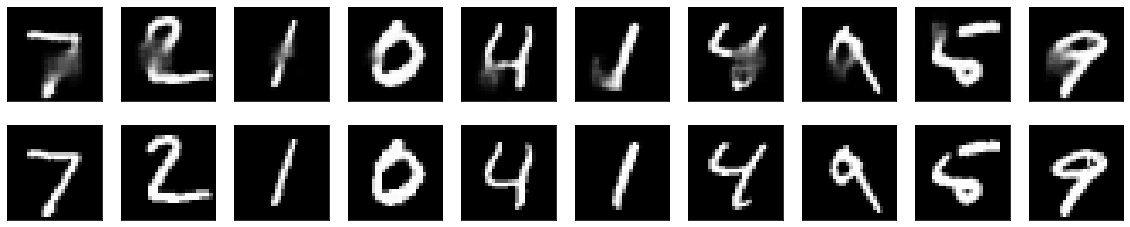

In [54]:
decoded_imgs = autoencoder._predict(x_test_noisy)
show_image_reconstructions(decoded_imgs, x_test)
'''
Below is the decoded noisy image
and its counterpart cleaned image
Still has some noise (such as 4)
But generally, it did clean up some parts but blurry
'''

In [0]:
'''
Second autoencoder that uses Dense Layers into input
'''
class DenseAutoEncoder(AutoEncoder):
  def __init__(self, image_size):
    latent_dim = 64
    input_shape = (image_size, image_size, 1)
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    
    layer_filters = [32, 64]
    
    for filters in layer_filters:
      x = Conv2D(filters=filters,
                 kernel_size=self.kernel_size,
                 strides=2,
                 padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

  # Shape info needed to build Decoder Model
    shape = K.int_shape(x)

    # Generate the latent vector
    x = Flatten()(x)
    latent = Dense(latent_dim, name='latent_vector')(x)

    # Instantiate Encoder Model
    encoder = Model(inputs, latent, name='encoder')
    encoder.summary()

    # Build the Decoder Model
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=self.kernel_size,
                            strides=2,
                            padding='same')(x)

        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = Conv2DTranspose(filters=1,
                        kernel_size=self.kernel_size,
                        padding='same')(x)

    outputs = Activation('sigmoid', name='decoder_output')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    # Autoencoder = Encoder + Decoder
    # Instantiate Autoencoder Model
    self.model = Model(inputs, decoder(encoder(inputs)), name='autoencoder')


In [64]:
loss = 'mse'
optimizer = 'adadelta'

autoencoder2 = DenseAutoEncoder(image_size)
autoencoder2._compile(loss, optimizer)
autoencoder2.summarize()
batch_size = 16
epochs = 20
print("Training autoencoder")
autoencoder2._train(x_train_noisy,
                x_train,
                x_test_noisy, 
                x_test,
                epochs=epochs,
                batch_size=batch_size)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_45 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
activation_39 (Activation)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_46 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
activation_40 (Activation)   (None, 7, 7, 64)          0   

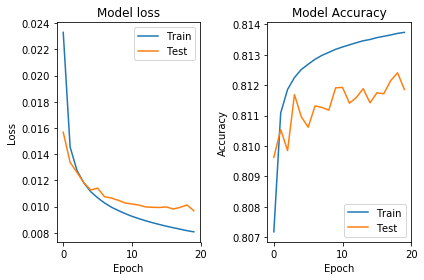

In [65]:
visualize(autoencoder2.get_history())
'''
Generally has a better graph and smoother than Convolutional Autoencoders (#1)
Loss is also lower.
Accuracy slightly higher
'''

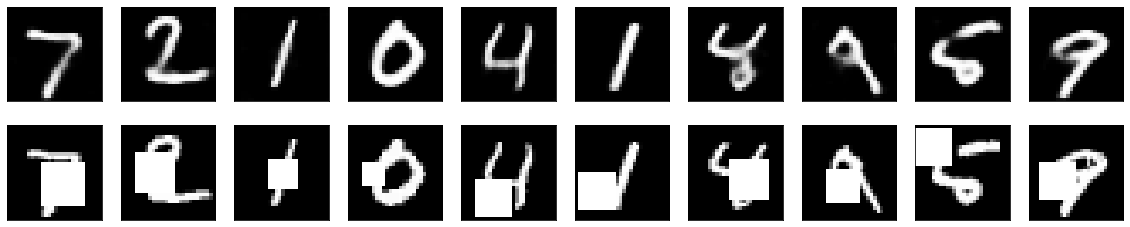

In [68]:
decoded2 = autoencoder2._predict(x_test_noisy)
show_image_reconstructions(decoded2, x_test_noisy)
'''
Drastically better than #1 on image even though there isnt much of a difference in val_accuracy and accuracy
Observation, I think it mistakes 7th image (#4) as 5
'''

In [69]:

'''
RESULTS and DISCUSSIONS

We are able to use Autoencoder to denoise an image by learning the loss between the denoised image and original image.
MNIST dataset is used.

DENOISING the image
We have the image corrupted by a white square of at most 25% of the image area and we have to retrieve it.
Created a function that randomly puts white blocks on an image

Model Selection/Summary
Autoencoders are composed of an encoder and a decoder, the decoder being the opposite of the encoder.
We can use a variety of architecture to tackle this problem and here, we used two different approaches.

1. Convolutional Layers + MaxPooling
We used convolutional layers with maxpool layers to denoise the image.
MaxPools are countered by Conv2DTranspose with stride=2 and size=2.
Here is the architecture

Layer (type)                 Output Shape              Param #   
=================================================================
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 8)         1160      
_________________________________________________________________
batch_normalization_29 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_23 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_transpose_48 (Conv2DT (None, 28, 28, 8)         264       
_________________________________________________________________
batch_normalization_30 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_24 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_transpose_49 (Conv2DT (None, 28, 28, 8)         584       
_________________________________________________________________
conv2d_transpose_50 (Conv2DT (None, 28, 28, 16)        1168      
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         145       
=================================================================

We also added Batch Normalization before each ReLU activation layers.
Observation: The loss had a rough progression bouncing back and forth.
Accuracy is already 0.8~ on the firs epoch and didn't really change that much.
Surprisingly trains faster per epoch than using Dense layers (#2)
I tried adding another Conv2D-MaxPool vs Conv2D-Conv2D reflection but it didnt really change the val_accuracy that much

2. Convolutional Layers -> Dense -> Conv2DTranspose
Here, we added a Dense layer as latent dimensional reduction in the middle.
Reshaped again to Conv2DTranspose. Conv2DTranspose is the opposite of Conv2D where it shrinks the filters.
Conclusion: There is no major/significant difference between the two architecture in terms of performance.
We tuned the latent dimension to higher = 64 rather than 16 expectng higher accuracy but no significant addition to accuracy.
## A lot better in image decoded than previous one

'''

"\nRESULTS and DISCUSSIONS\n\nWe are able to use Autoencoder to denoise an image by learning the loss between the denoised image and original image.\nMNIST dataset is used.\n\nDENOISING the image\nWe have the image corrupted by a white square of at most 25% of the image area and we have to retrieve it.\nCreated a function that randomly puts white blocks on an image\n\nModel Selection/Summary\nAutoencoders are composed of an encoder and a decoder, the decoder being the opposite of the encoder.\nWe can use a variety of architecture to tackle this problem and here, we used two different approaches.\n\n1. Convolutional Layers + MaxPooling\nWe used convolutional layers with maxpool layers to denoise the image.\nMaxPools are countered by Conv2DTranspose with stride=2 and size=2.\nHere is the architecture\n\nLayer (type)                 Output Shape              Param #   \n=================================================================\nencoder_input (InputLayer)   (None, 28, 28, 1)       

In [75]:
from keras.models import Sequential
from keras.layers import Flatten
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10
input_shape = (1, img_rows, img_cols) if K.image_data_format() == 'channels_first' else (img_rows, img_cols, 1)

classifier = Sequential([
    Conv2D(32, 5, activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(64, 5, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(600, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

###########################################################################################################
# transforms.py
def corrupt_mnist_img(rng, img, value):
    """Corrupt a single MNIST image.
    Note that the image itself is MODIFIED.
    :param rng: instance of numpy.random.RandomState
    :param img: image to modify. ndarray or compatible
    :param value: pixel value to use for corrupting the image
    :return: modified image
    """
    # Choose square size
    s = rng.randint(7, 15)
    # Choose top-left corner position
    x = rng.randint(0, 29 - s)
    y = rng.randint(0, 29 - s)
    # Draw square
    img[..., y:y + s, x:x + s] = value
    # Return object for convenience
    return img


def corrupt_mnist_copy(x_train, value=255, seed=0):
    """Create a corrupted copy of the MNIST dataset
    :param x_train: ndarray of images. Shape: (N, ..., H, W)
    :param value: pixel value to use for corrupting the image
    :param seed: seed to use for the random number generator
    :return: ndarray of corrupted images
    :return: ndarray of corrupted images
    """
    rng = np.random.RandomState(seed)
    corrupted_x_train = x_train.copy()
    for img in corrupted_x_train:
        corrupt_mnist_img(rng, img, value)
    return corrupted_x_train


def corrupt_mnist_generator(x_train, value=255, seed=0):
    """Generator version of `corrupt_mnist_copy()`
    :param x_train:
    :param value:
    :param seed:
    :return:
    """
    rng = np.random.RandomState(seed)
    while True:
        for img in x_train:
            yield corrupt_mnist_img(rng, img.copy(), value)


class CorruptMNIST(object):
    """PyTorch transform for corrupting MNIST images
    Use after ToTensor and before Normalize.
    """

    def __init__(self, seed=0):
        self._rng = np.random.RandomState(seed)

    def __call__(self, img):
        return corrupt_mnist_img(self._rng, img, 1.)

    def __repr__(self):
        return self.__class__.__name__ + '()'

      
###########################################################################################################
# structural_similarity.py
from scipy.ndimage import uniform_filter, gaussian_filter

from skimage.util.dtype import dtype_range
from skimage.util.arraycrop import crop
from skimage._shared.utils import warn

__all__ = ['structural_similarity']

# Extracted from: https://github.com/scikit-image/scikit-image/blob/master/skimage/_shared/utils.py
def check_shape_equality(im1, im2):
    """Raise an error if the shape do not match."""
    if not im1.shape == im2.shape:
        raise ValueError('Input images must have the same dimensions.')
    return


def structural_similarity(im1, im2,
                          *,
                          win_size=None, gradient=False, data_range=None,
                          multichannel=False, gaussian_weights=False,
                          full=False, **kwargs):
    """
    Compute the mean structural similarity index between two images.
    Parameters
    ----------
    im1, im2 : ndarray
        Images. Any dimensionality with same shape.
    win_size : int or None, optional
        The side-length of the sliding window used in comparison. Must be an
        odd value. If `gaussian_weights` is True, this is ignored and the
        window size will depend on `sigma`.
    gradient : bool, optional
        If True, also return the gradient with respect to im2.
    data_range : float, optional
        The data range of the input image (distance between minimum and
        maximum possible values). By default, this is estimated from the image
        data-type.
    multichannel : bool, optional
        If True, treat the last dimension of the array as channels. Similarity
        calculations are done independently for each channel then averaged.
    gaussian_weights : bool, optional
        If True, each patch has its mean and variance spatially weighted by a
        normalized Gaussian kernel of width sigma=1.5.
    full : bool, optional
        If True, also return the full structural similarity image.
    Other Parameters
    ----------------
    use_sample_covariance : bool
        If True, normalize covariances by N-1 rather than, N where N is the
        number of pixels within the sliding window.
    K1 : float
        Algorithm parameter, K1 (small constant, see [1]_).
    K2 : float
        Algorithm parameter, K2 (small constant, see [1]_).
    sigma : float
        Standard deviation for the Gaussian when `gaussian_weights` is True.
    Returns
    -------
    mssim : float
        The mean structural similarity index over the image.
    grad : ndarray
        The gradient of the structural similarity between im1 and im2 [2]_.
        This is only returned if `gradient` is set to True.
    S : ndarray
        The full SSIM image.  This is only returned if `full` is set to True.
    Notes
    -----
    To match the implementation of Wang et. al. [1]_, set `gaussian_weights`
    to True, `sigma` to 1.5, and `use_sample_covariance` to False.
    .. versionchanged:: 0.16
        This function was renamed from ``skimage.measure.compare_ssim`` to
        ``skimage.metrics.structural_similarity``.
    References
    ----------
    .. [1] Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P.
       (2004). Image quality assessment: From error visibility to
       structural similarity. IEEE Transactions on Image Processing,
       13, 600-612.
       https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf,
       :DOI:`10.1109/TIP.2003.819861`
    .. [2] Avanaki, A. N. (2009). Exact global histogram specification
       optimized for structural similarity. Optical Review, 16, 613-621.
       :arxiv:`0901.0065`
       :DOI:`10.1007/s10043-009-0119-z`
    """
    check_shape_equality(im1, im2)

    if multichannel:
        # loop over channels
        args = dict(win_size=win_size,
                    gradient=gradient,
                    data_range=data_range,
                    multichannel=False,
                    gaussian_weights=gaussian_weights,
                    full=full)
        args.update(kwargs)
        nch = im1.shape[-1]
        mssim = np.empty(nch)
        if gradient:
            G = np.empty(im1.shape)
        if full:
            S = np.empty(im1.shape)
        for ch in range(nch):
            ch_result = structural_similarity(im1[..., ch],
                                              im2[..., ch], **args)
            if gradient and full:
                mssim[..., ch], G[..., ch], S[..., ch] = ch_result
            elif gradient:
                mssim[..., ch], G[..., ch] = ch_result
            elif full:
                mssim[..., ch], S[..., ch] = ch_result
            else:
                mssim[..., ch] = ch_result
        mssim = mssim.mean()
        if gradient and full:
            return mssim, G, S
        elif gradient:
            return mssim, G
        elif full:
            return mssim, S
        else:
            return mssim

    K1 = kwargs.pop('K1', 0.01)
    K2 = kwargs.pop('K2', 0.03)
    sigma = kwargs.pop('sigma', 1.5)
    if K1 < 0:
        raise ValueError("K1 must be positive")
    if K2 < 0:
        raise ValueError("K2 must be positive")
    if sigma < 0:
        raise ValueError("sigma must be positive")
    use_sample_covariance = kwargs.pop('use_sample_covariance', True)

    if gaussian_weights:
        # Set to give an 11-tap filter with the default sigma of 1.5 to match
        # Wang et. al. 2004.
        truncate = 3.5

    if win_size is None:
        if gaussian_weights:
            # set win_size used by crop to match the filter size
            r = int(truncate * sigma + 0.5)  # radius as in ndimage
            win_size = 2 * r + 1
        else:
            win_size = 7   # backwards compatibility

    if np.any((np.asarray(im1.shape) - win_size) < 0):
        raise ValueError(
            "win_size exceeds image extent.  If the input is a multichannel "
            "(color) image, set multichannel=True.")

    if not (win_size % 2 == 1):
        raise ValueError('Window size must be odd.')

    if data_range is None:
        if im1.dtype != im2.dtype:
            warn("Inputs have mismatched dtype.  Setting data_range based on "
                 "im1.dtype.", stacklevel=2)
        dmin, dmax = dtype_range[im1.dtype.type]
        data_range = dmax - dmin

    ndim = im1.ndim

    if gaussian_weights:
        filter_func = gaussian_filter
        filter_args = {'sigma': sigma, 'truncate': truncate}
    else:
        filter_func = uniform_filter
        filter_args = {'size': win_size}

    # ndimage filters need floating point data
    im1 = im1.astype(np.float64)
    im2 = im2.astype(np.float64)

    NP = win_size ** ndim

    # filter has already normalized by NP
    if use_sample_covariance:
        cov_norm = NP / (NP - 1)  # sample covariance
    else:
        cov_norm = 1.0  # population covariance to match Wang et. al. 2004

    # compute (weighted) means
    ux = filter_func(im1, **filter_args)
    uy = filter_func(im2, **filter_args)

    # compute (weighted) variances and covariances
    uxx = filter_func(im1 * im1, **filter_args)
    uyy = filter_func(im2 * im2, **filter_args)
    uxy = filter_func(im1 * im2, **filter_args)
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim
    mssim = crop(S, pad).mean()

    if gradient:
        # The following is Eqs. 7-8 of Avanaki 2009.
        grad = filter_func(A1 / D, **filter_args) * im1
        grad += filter_func(-S / B2, **filter_args) * im2
        grad += filter_func((ux * (A2 - A1) - uy * (B2 - B1) * S) / D,
                            **filter_args)
        grad *= (2 / im1.size)

        if full:
            return mssim, grad, S
        else:
            return mssim, grad
    else:
        if full:
            return mssim, S
        else:
            return mssim
          
###########################################################################################################
# benchmark_keras.py
class IdentityModel(Model):
    """Model which simply returns the input"""

    def __init__(self):
        super().__init__()
        self.identity = keras.layers.Lambda(lambda x: x)

    def call(self, x):
        return self.identity(x)


def _preprocess_for_classifier(x):
    return (x - 0.1307) / 0.3081


def test_model(model, x_test, y_test, batch_size=100):
    """Run the benchmarks for the given model
    :param model:
    :param x_test: MNIST images scaled to [0, 1]
    :param y_test: MNIST labels, raw values, not one-hot vectors
    :param batch_size: batch size to use for evaluation
    :return: None
    """
    rng = np.random.RandomState(0)

    classifier.load_weights('mnist_cnn.h5')

    baseline_score = 0
    correct_score = 0
    ssim_score = 0

    N = len(x_test)
    assert N % batch_size == 0, 'N should be divisible by batch_size'
    num_batches = N // batch_size

    for i in range(num_batches):
        imgs_orig = x_test[batch_size * i:batch_size * (i + 1)].astype(K.floatx())
        labels = y_test[batch_size * i:batch_size * (i + 1)]
        # Create corruption masks
        masks = []
        for _ in range(batch_size):
            # Choose square size
            s = rng.randint(7, 15)
            # Choose top-left corner position
            x = rng.randint(0, 29 - s)
            y = rng.randint(0, 29 - s)
            mask = np.zeros(imgs_orig.shape[1:], dtype=np.bool)
            # Set mask area
            mask[y:y + s, x:x + s] = True
            masks.append(mask)
        masks = np.stack(masks)

        # Add channel dimension
        channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
        imgs_orig = np.expand_dims(imgs_orig, channel_dim)
        masks = np.expand_dims(masks, channel_dim)

        # Generate corrupted versions
        imgs_corrupted = imgs_orig.copy()
        imgs_corrupted[masks] = 1.

        # Generate restored images
        imgs_restored = model.predict_on_batch(imgs_corrupted)

        predicted_labels_orig = classifier.predict_on_batch(_preprocess_for_classifier(imgs_orig)).argmax(axis=-1).astype(labels.dtype)
        predicted_labels_restored = classifier.predict_on_batch(_preprocess_for_classifier(imgs_restored)).argmax(axis=-1).astype(labels.dtype)
        # Calculate classifier score:
        # baseline corresponds to the original samples which the classifier is able to correctly predict
        baseline = labels == predicted_labels_orig
        # Since the classifier is NOT 100% accurate, we ignore the prediction results
        # from the original samples which were misclassified by masking it using the baseline.
        correct = (labels == predicted_labels_restored) & baseline
        baseline_score += int(baseline.sum())
        correct_score += int(correct.sum())

        # Compute SSIM over the uncorrupted pixels
        imgs_orig[masks] = 0.
        imgs_restored[masks] = 0.
        imgs_orig = imgs_orig.squeeze()
        imgs_restored = imgs_restored.squeeze()
        for j in range(batch_size):
            ssim_score += structural_similarity(imgs_orig[j], imgs_restored[j])

    classifier_score = correct_score / baseline_score
    ssim_score /= N

    print('Classifier score: {:.2f}\nSSIM score: {:.2f}'.format(100 * classifier_score, 100 * ssim_score))

print("Model 2 Scores")
(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()
x_test2 = x_test2 / 255
test_model(autoencoder2.get_model(), x_test2, y_test2)

Model 2 Scores
Classifier score: 96.82
SSIM score: 96.39


In [76]:
print("Model 1 Scores")
(x_train3, y_train3), (x_test3, y_test3) = mnist.load_data()
x_test3 = x_test3 / 255
test_model(autoencoder.get_model(), x_test3, y_test3)

Model 1 Scores
Classifier score: 96.13
SSIM score: 99.11


In [0]:
'''
Classifier Score: Measures quality of inpainting
SSIM score: Measures capability to detect and preserve uncorrupted pixels

Surprising, Model 1 scored better in SSIM against Model 2. I think this is because the Conv layers are
great in preserving the unchanged pixels because it does not have to transform it into Dense layer which changes the quality of some pixels.

Still, Model 2 is better in classifier scores as it is better in decoding corrupted parts thanks to the latent representation where it
just preserves the most significant pixels (hopefully)
'''